# 1.9 Exercises
## 1.9.1 Business Cycle Regularities in South Korea and the United States
In this exercise, you are asked to analyze the extend to which the numbered business cycle facts discussed in this chapter apply to (a) South Korea and (b) The United States. To this end compute the relevant business cycle statistics for the following four alternative detrending methods: 
(a) log-linear detrending; 
(b) log-quadratic detrending; 
(c) Hodrick Prescott filtering with λ = 100;
(d) Hodrick Prescott filtering with λ = 6.25. 
Make a two by two graph showing the natural logarithm of real per capita GDP and the trend, one panel per trend. Discuss how the detrending method influences the volatility of the cyclical component of output. Also discuss which detrending method identifies recessions for the U.S. most in line with the NBER business cycle dates. The data should be downloaded from the World Bank’s WDI database. As the sample period for South Korea use 1960 to 2011 and for the United States use 1965-2011. Specifically, use the following time series to construct the required business cycle statistics:

GDP per capita (constant LCU) NY.GDP.PCAP.KN

Household final consumption expenditure, etc. (% of GDP) NE.CON.PETC.ZS

Gross capital formation (% of GDP) NE.GDI.TOTL.ZS

General government final consumption expenditure (% of GDP) NE.CON.GOVT.ZS

Imports of goods and services (% of GDP) NE.IMP.GNFS.ZS

Exports of goods and services (% of GDP) NE.EXP.GNFS.ZS


## Подготовка

Первым делом необходимо добавить необходимые библиотеки

In [1]:
import pandas as pd # Данные
import matplotlib.pyplot as plt # Графики
import requests # Запрос данных
import numpy as np # Работа с данныеми
import statsmodels.api as sm # Статистические модели 

Опишем функцию 

In [2]:
# Массив индикаторов индикаторов
indicators = [
    'NY.GDP.PCAP.KN',  
    'NE.CON.PRVT.ZS',  
    'NE.GDI.TOTL.ZS',  
    'NE.CON.GOVT.ZS',  
    'NE.IMP.GNFS.ZS',  
    'NE.EXP.GNFS.ZS'  
]

# Словарь описаний индикаторов
indicators_info = {
    indicators[0]:'GDP per capita',    
    indicators[1]:'Households and NPISHs final consumption expenditure',    
    indicators[2]:'Gross capital formation',    
    indicators[3]:'General government final consumption expenditure',    
    indicators[4]:'Imports of goods and services',    
    indicators[5]:'Exports of goods and services',    
}

# Классический метод с примера worldbank
def get_data(country):

    url = f'https://api.worldbank.org/v2/country/{country}/indicator/'
    imported_data = pd.DataFrame(columns = ['Country', 'Indicator', 'Year', 'Value'])

    for indicator in indicators:
        api_url = url + indicator

        response = requests.get(api_url, params = {
            'format': 'json',
            'per_page': 500 })

        if response.status_code == 200:
            data = response.json()
            if len(data) <= 1:
                continue
            else:
                # Обработка полученных данных
                for entry in data[1]:
                    new_row = pd.Series([entry['country']['value'], indicator, entry['date'], entry['value']], index = imported_data.columns)
                    imported_data.loc[len(imported_data)] =  new_row
        else:
            print('Data get error.')
    return imported_data

Получим данные

In [3]:
usa_data = get_data('US') # USA
aus_data = get_data('AT') # Austria

Проверка корректности данных путём построения простого графика

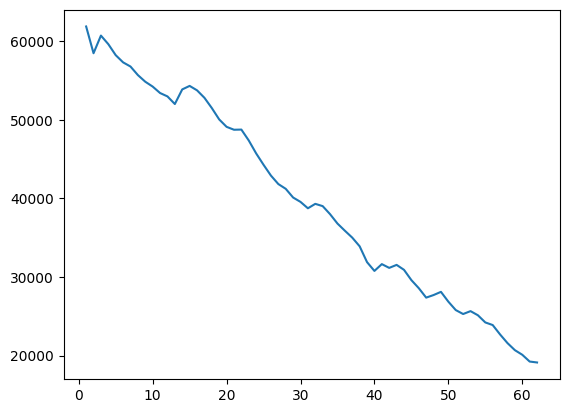

In [4]:
plt.plot(usa_data[usa_data.Indicator == indicators[0]].Value)

Видим что данные имеют неправильный разворот. Нужно развернуть данные и сделать реиндексацию

In [5]:
usa_data = usa_data.iloc[::-1].reset_index().drop('index', axis = 1)
aus_data = aus_data.iloc[::-1].reset_index().drop('index', axis = 1)

Обрежим данные и сделаем их с 1970 по 2021

In [6]:
usa_data = usa_data[(usa_data.Year.astype(int) >= 1970) & (usa_data.Year.astype(int) <= 2021)]
aus_data = aus_data[(aus_data.Year.astype(int) >= 1970) & (aus_data.Year.astype(int) <= 2021)]

Строим ещё раз график для теста

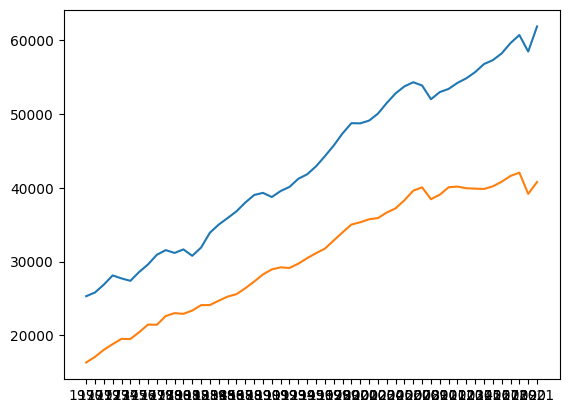

In [7]:
plt.plot(usa_data[usa_data.Indicator == indicators[0]].Year, usa_data[usa_data.Indicator == indicators[0]].Value)
plt.plot(usa_data[usa_data.Indicator == indicators[0]].Year, aus_data[aus_data.Indicator == indicators[0]].Value)

Данные готовы к работе

### Получение логарифмированных значений

In [8]:
usa_data_log = usa_data.copy()
aus_data_log = aus_data.copy()
for indicator in indicators:
    usa_data_log.loc[usa_data_log.Indicator == indicator, 'Value'] = \
        np.log(usa_data[usa_data.Indicator == indicator]['Value'].astype(float))
    aus_data_log.loc[aus_data_log.Indicator == indicator, 'Value'] = \
        np.log(aus_data[aus_data.Indicator == indicator]['Value'].astype(float))

## Реализация всех необходимых методов
Для удобной работы необходимо реализовать все методы, чтобы в дальнейшем можно было оперативно работать с данными

### Первая часть задания

Реализация методов детрендинга: (a) log-linear detrending; (b) log-quadratic detrending; (c) Hodrick Prescott filtering with λ = 100; (d) Hodrick Prescott filtering with λ = 6.25. 

In [9]:
methods = ['log-linear','log-quad', 'hp-filter100', 'hp-filter6.25']
# (a) log-linear detrending;
def log_linear_detrending(input_data, indicator = 'NY.GDP.PCAP.KN', is_print_summary = True):
    data = pd.DataFrame({'x': input_data[input_data.Indicator == indicator].Value.astype(float),\
                         'y': input_data[input_data.Indicator == indicator].Year.astype(int)})
    data = sm.add_constant(data)
    model = sm.OLS(data['x'], data[['const', 'y']])
    result = model.fit()
    if is_print_summary:
        print("Statistic for log_linear_detrending")
        print(result.summary())
    trend = result.predict(data[['const', 'y']])
    cycle = data['x'] - trend
    return cycle, trend

# (b) log-quadratic detrending;
def log_quad_detrending(input_data, indicator = 'NY.GDP.PCAP.KN', is_print_summary = True):
    data = pd.DataFrame({'x': input_data[input_data.Indicator == indicator].Value.astype(float),\
                         'y': input_data[input_data.Indicator == indicator].Year.astype(int)})
    log_y = np.log(data.y) 
    coefs = np.polyfit(data.y, data.x, 2) 
    trend = np.polyval(coefs, data.y)
    cycle = data['x'] - trend
    if is_print_summary:
        print("\nStatistic for log_quad_detrending")
        print(pd.DataFrame(trend).describe())
    return cycle, trend

# (c) Hodrick Prescott filtering with λ = 100; (d) Hodrick Prescott filtering with λ = 6.25. 
def hp_filter(input_data, indicator = 'NY.GDP.PCAP.KN', lambda_value = 100, is_print_summary = True):
    cycle, trend = sm.tsa.filters.hpfilter(input_data[input_data.Indicator == indicator].Value.astype(float), lambda_value)
    if is_print_summary:
        print(f"\nStatistic for hp_filter with lambda = {lambda_value}")
        print(pd.DataFrame(trend).describe())
    return cycle, trend

Реализуем метод для демонстрации наших графиков

In [10]:
def show_plot(ticks, x_data, y_data_1, y_data_2, y_data_1_label, y_data_2_label):
    _, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xticks(ticks)
    axs.set_xlabel("Year")
    axs.plot(x_data, y_data_1 , label = y_data_1_label)
    #if y_data_2 != None:
    axs.plot(x_data, y_data_2, label=  y_data_2_label)
    axs.legend()
    plt.tight_layout()
    plt.show()

def show_data_by_indicator(y_data_1, y_data_2, y_data_1_label, y_data_2_label, indicator = 'NY.GDP.PCAP.KN'):
    year_array = y_data_1[y_data_1.Indicator == indicator].Year.astype(int)
    ticks = np.arange(int(min(year_array)), \
                      int(max(year_array)) + 1, 10)
    y_1 = y_data_1[y_data_1.Indicator == indicator].Value
    y_2 = y_data_2
    show_plot(ticks, year_array, y_1, y_2, y_data_1_label, y_data_2_label)

def show_oneline_plot(ticks, x_data, y_data_1, y_data_1_label):
    _, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xticks(ticks)
    axs.set_xlabel("Year")
    axs.plot(x_data, y_data_1 , label = y_data_1_label)
    axs.axhline(y = 0, color = 'red', linestyle = '--')
    axs.legend()
    plt.tight_layout()
    plt.show()

In [11]:
# Метод для выполнения первой части задания(демонстрация графиков GDP для разных циклов)
def solve_first_part_of_task(data, indicators):
    # Получаем цикл и тренд для лог-линейного
    cycle_ll, trend_ll = log_linear_detrending(data)
    # Получаем цикл и тренд для лог-квадратичного
    cycle_lq, trend_lq = log_quad_detrending(data)
    # Получаем цикл и тренд для hp-filter with lambda = 100
    cycle_ht, trend_ht = hp_filter(data)
    # Получаем цикл и тренд для hp-filter with lambda = 6.25
    cycle_hl, trend_hl = hp_filter(data, indicators[0], 6.25)
    #Строим значения
    show_data_by_indicator(data, trend_ll, "log GDP data", "Log-linear trend")
    show_data_by_indicator(data, trend_lq, "log GDP data", "Log-quad trend")
    show_data_by_indicator(data, trend_ht, "log GDP data", "hp-filter with lambda = 100 trend")
    show_data_by_indicator(data, trend_hl, "log GDP data", "hp-filter with lambda = 6.25 trend")
    year_data = data[data.Indicator == indicators[0]].Year.astype(int)
    ticks = np.arange(int(min(year_data)), \
                      int(max(year_data)) + 1, 10)
    show_oneline_plot(ticks, year_data, cycle_ll, "Log-linear cycle")
    show_oneline_plot(ticks, year_data, cycle_lq, "Log-quad cycle")
    show_oneline_plot(ticks, year_data, cycle_ht, "hp-filter with lambda = 100 trend")
    show_oneline_plot(ticks, year_data, cycle_hl, "hp-filter with lambda = 6.25 trend")
    # Дополнительно построим график со всем циклами на одном графике
    _, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xticks(ticks)
    axs.set_xlabel("Year")
    axs.plot(year_data, cycle_ll , label = "Log-linear cycle")
    axs.plot(year_data, cycle_lq , label = "Log-quad cycle")
    axs.plot(year_data, cycle_ht , label = "hp-filter with lambda = 100 trend")
    axs.plot(year_data, cycle_hl , label = "hp-filter with lambda = 6.25 trend")
    axs.axhline(y = 0, color = 'red', linestyle = '--')
    axs.legend()
    plt.tight_layout()
    plt.show()
    return {'log-linear': [cycle_ll, trend_ll],
            'log-quad': [cycle_lq, trend_lq],
            'hp-filter100': [cycle_ht, trend_ht],
            'hp-filter6.25': [cycle_hl, trend_hl]}

#### Результаты первой части для США

Statistic for log_linear_detrending
                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2007.
Date:                Sat, 27 May 2023   Prob (F-statistic):           5.01e-42
Time:                        19:36:57   Log-Likelihood:                 91.286
No. Observations:                  52   AIC:                            -178.6
Df Residuals:                      50   BIC:                            -174.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24

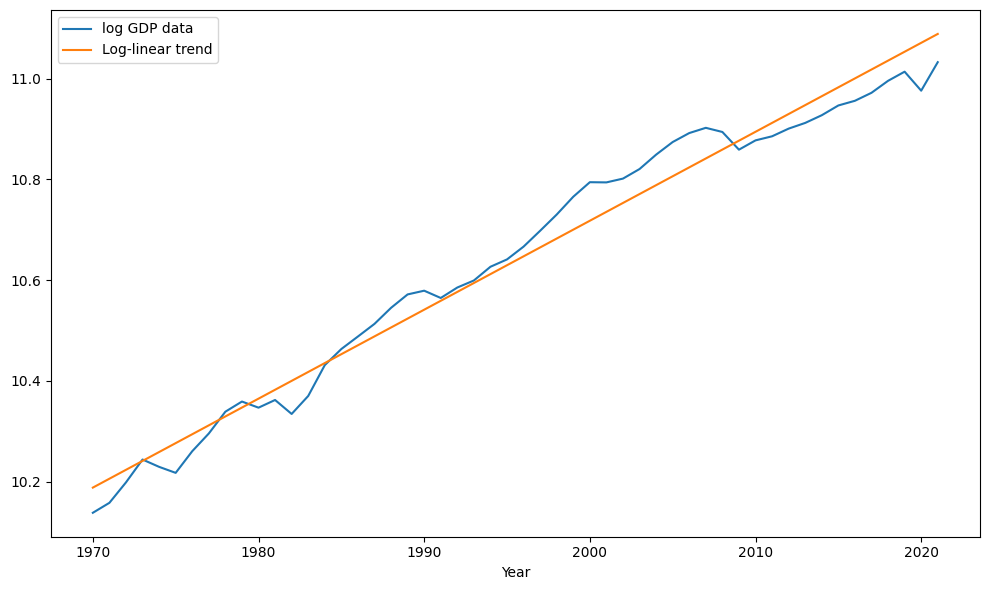

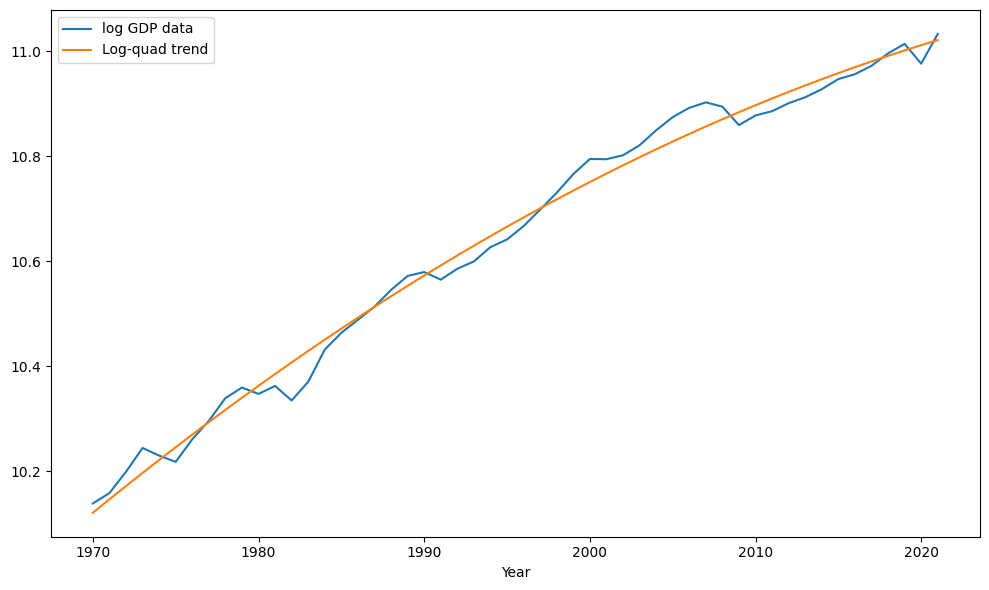

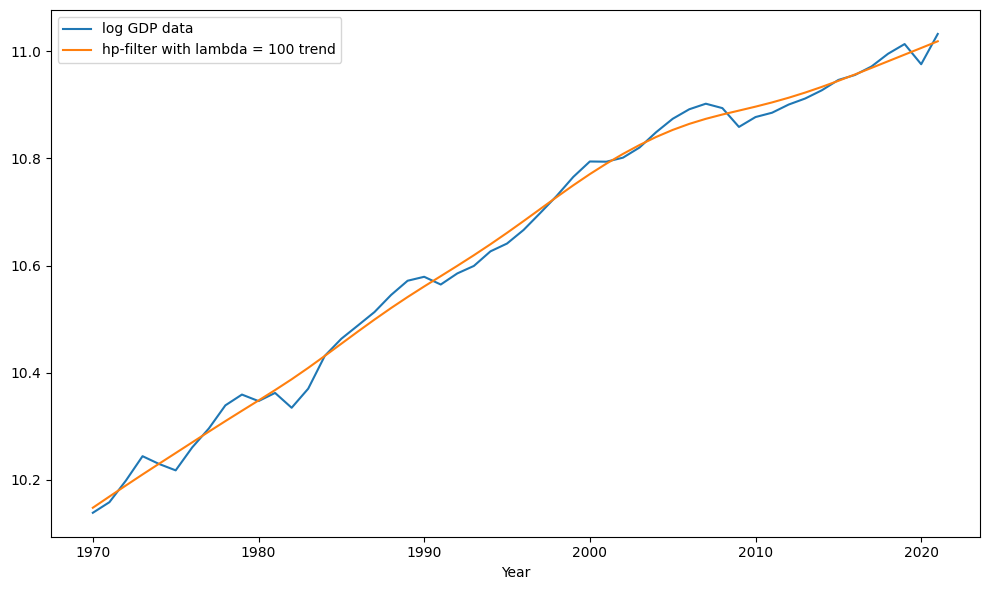

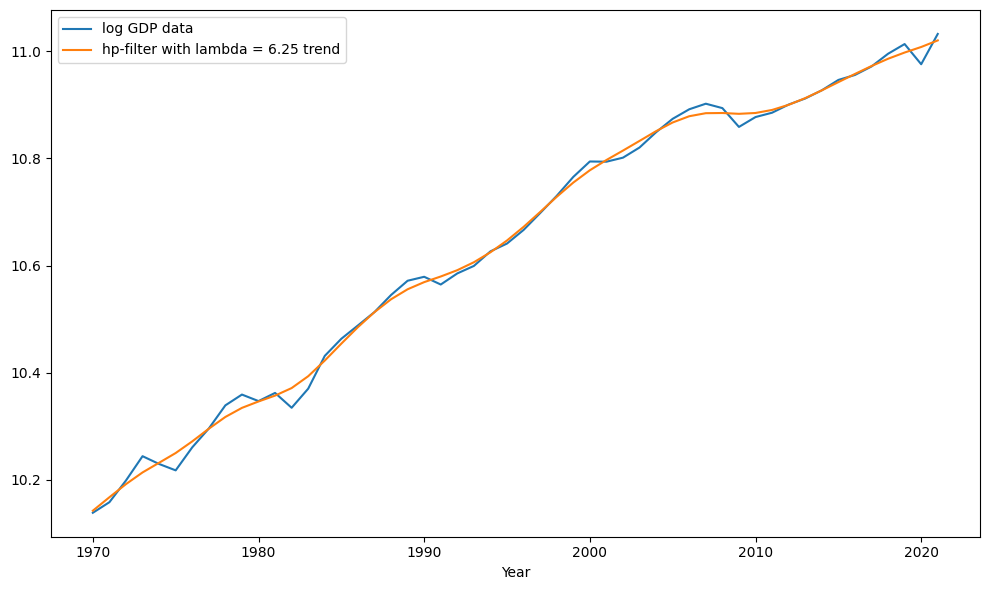

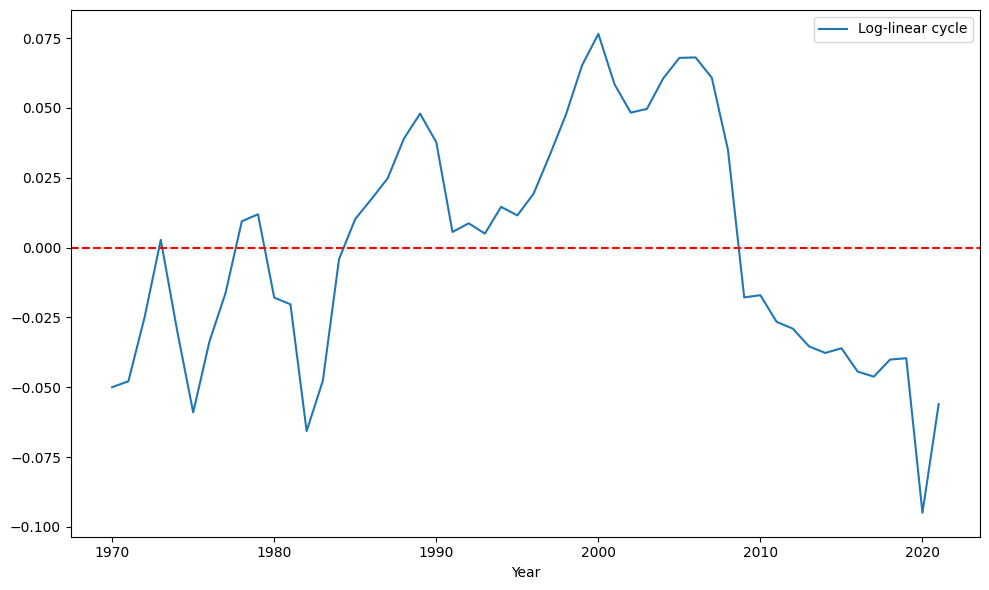

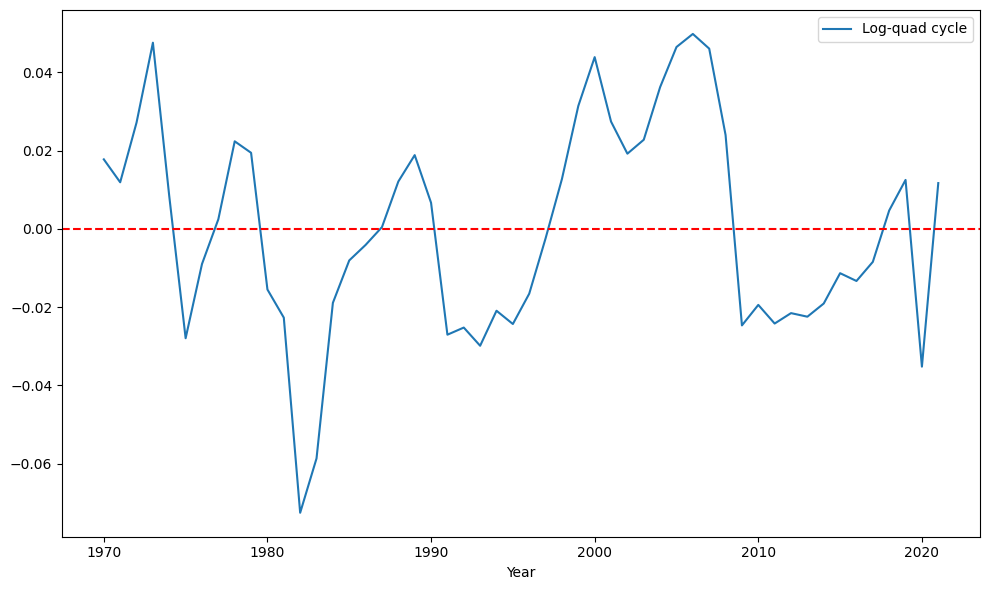

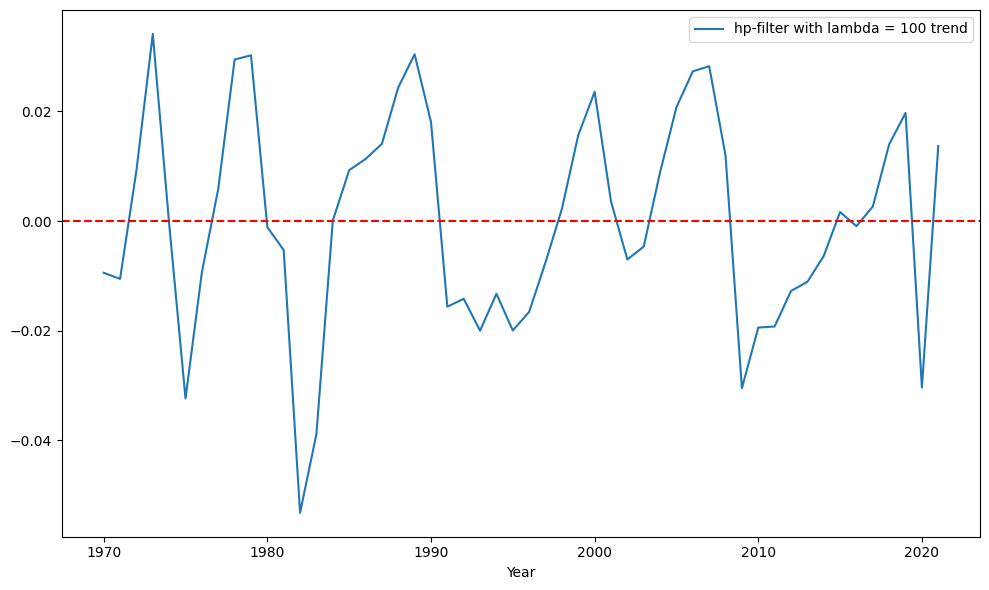

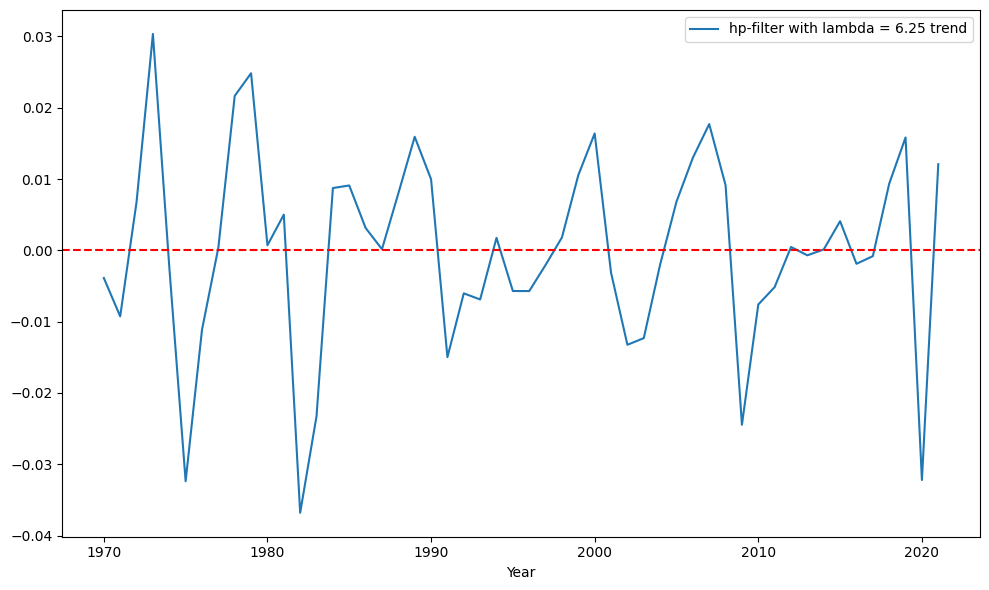

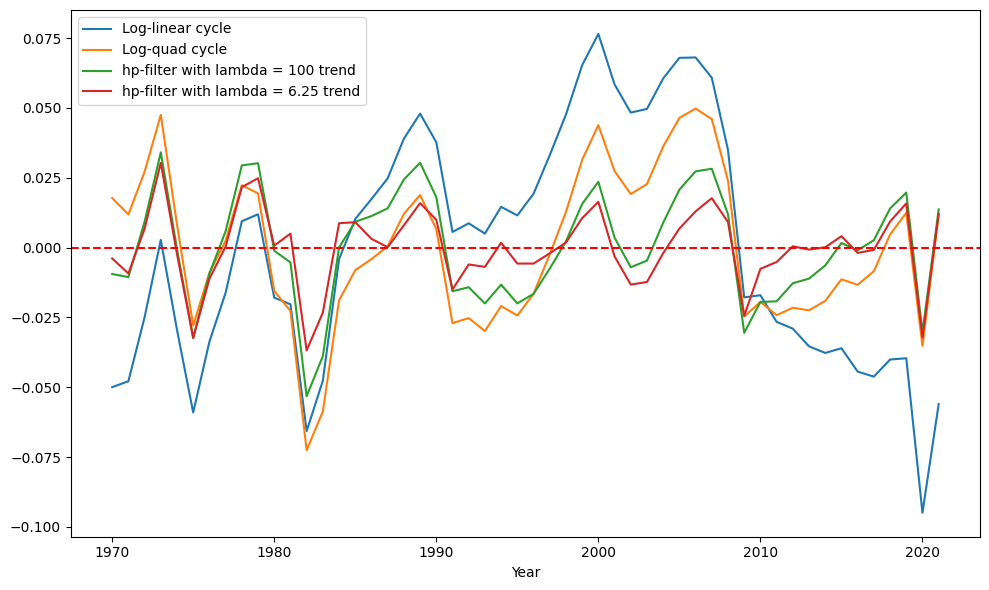

In [12]:
usa_result_1 = solve_first_part_of_task(usa_data_log, indicators)

По графику сравнения всех циклов можно видеть что нет схожих циклов, но лог-линейный цикл имеет большое отклонение как в начале, так и в конце от остальных циклов

#### Результаты первой части для Австрии

Statistic for log_linear_detrending
                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sat, 27 May 2023   Prob (F-statistic):           5.43e-35
Time:                        19:36:58   Log-Likelihood:                 72.898
No. Observations:                  52   AIC:                            -141.8
Df Residuals:                      50   BIC:                            -137.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25

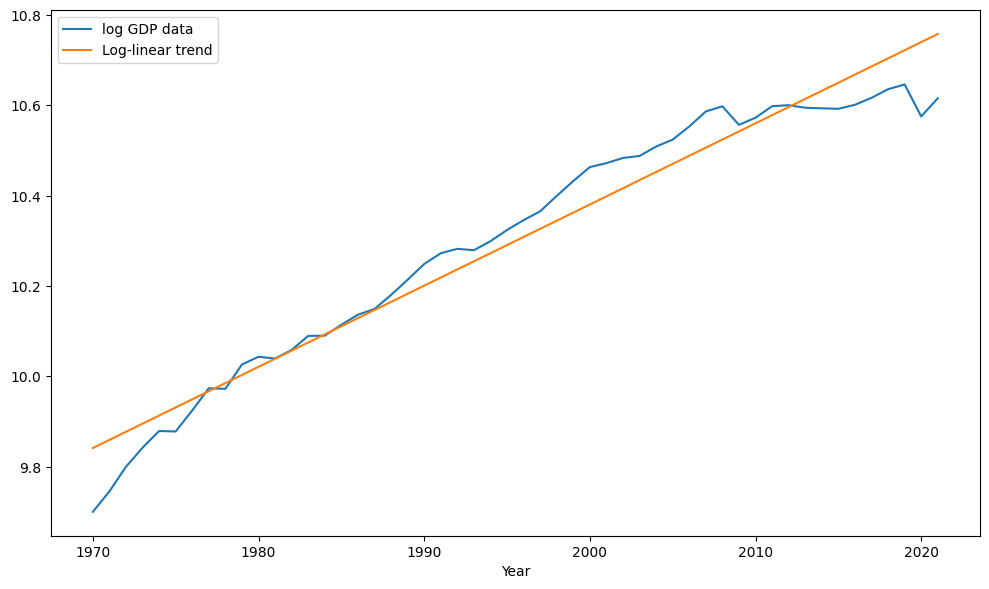

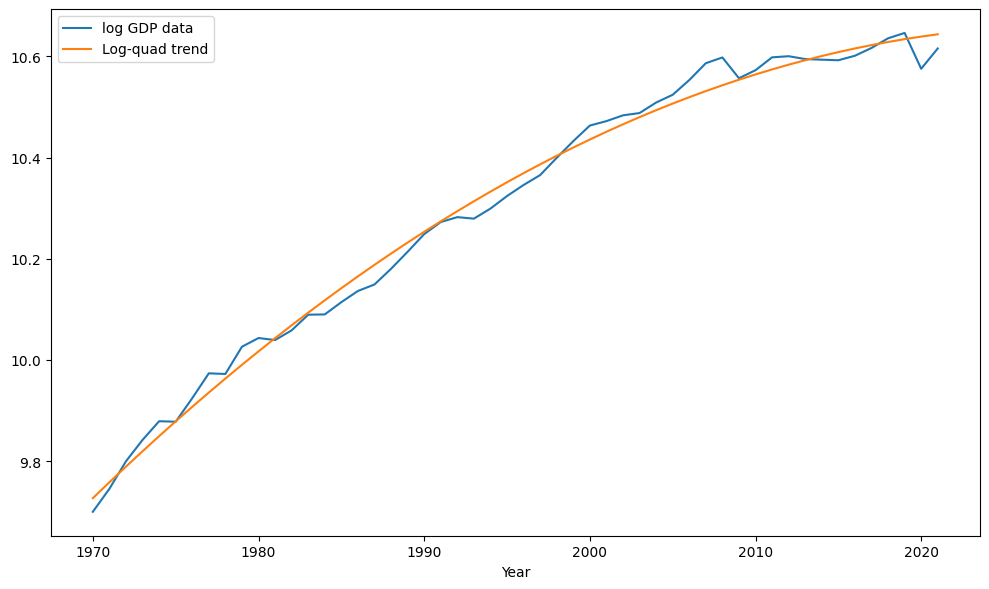

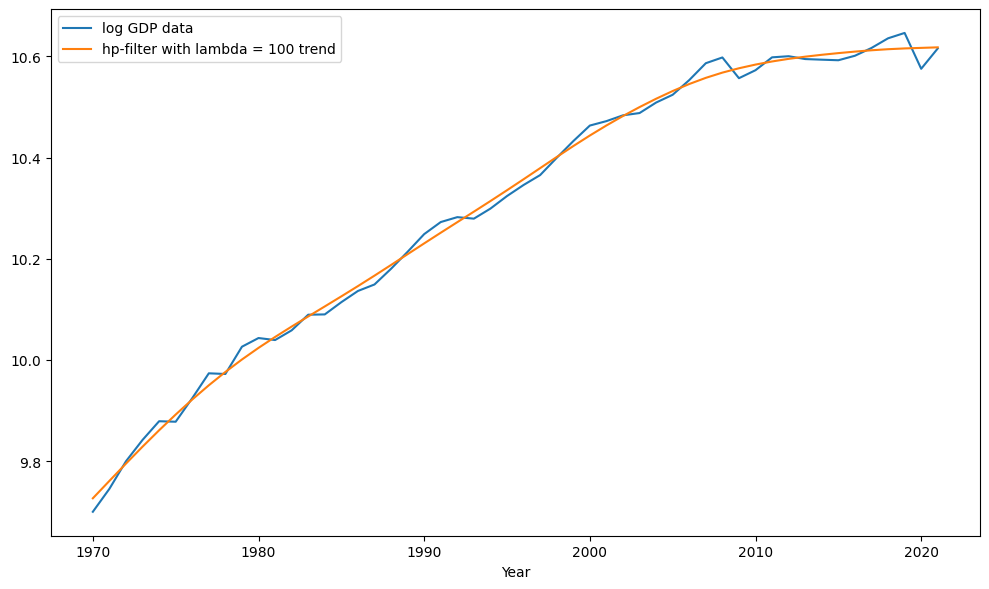

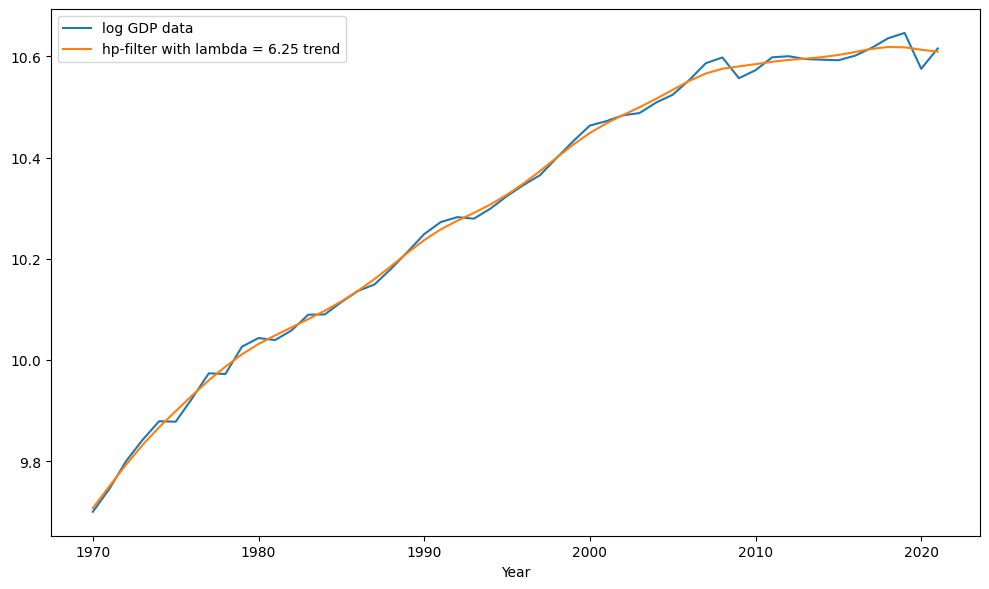

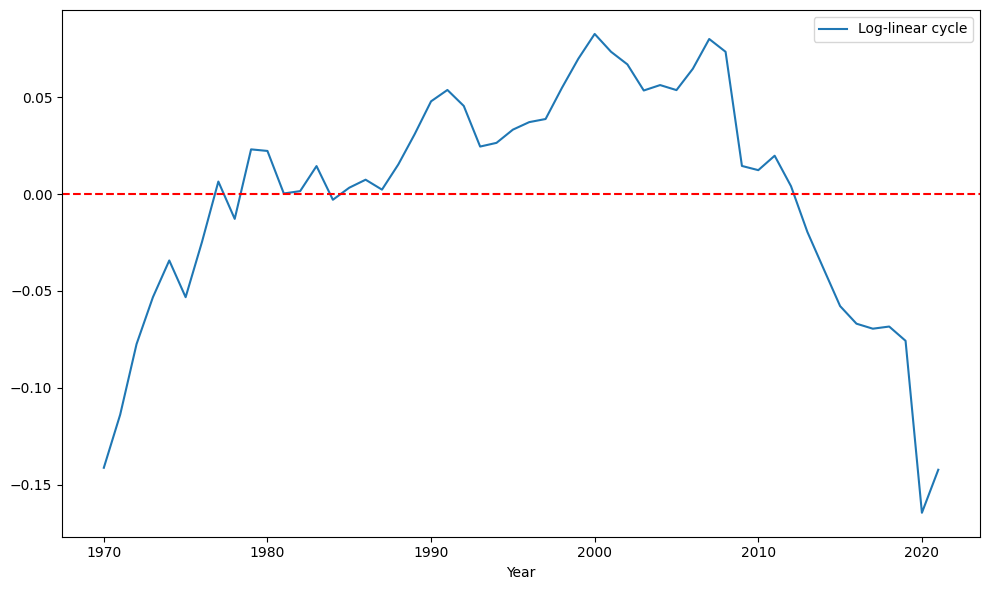

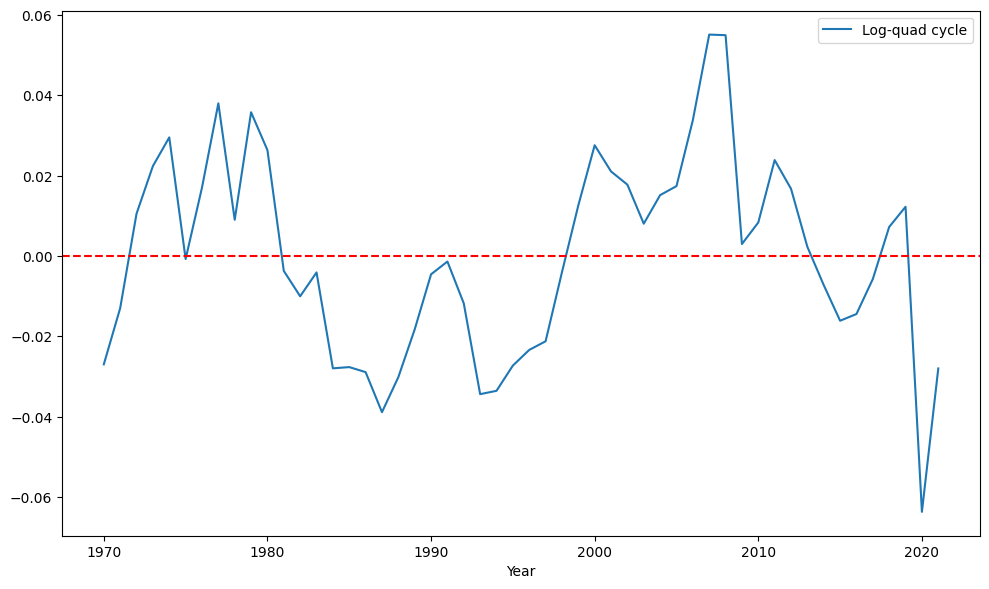

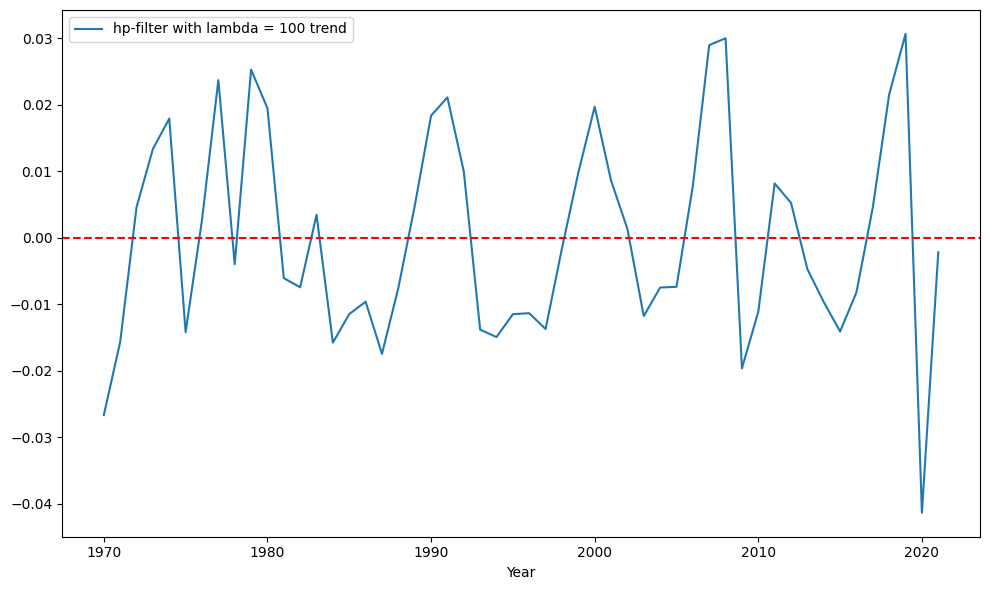

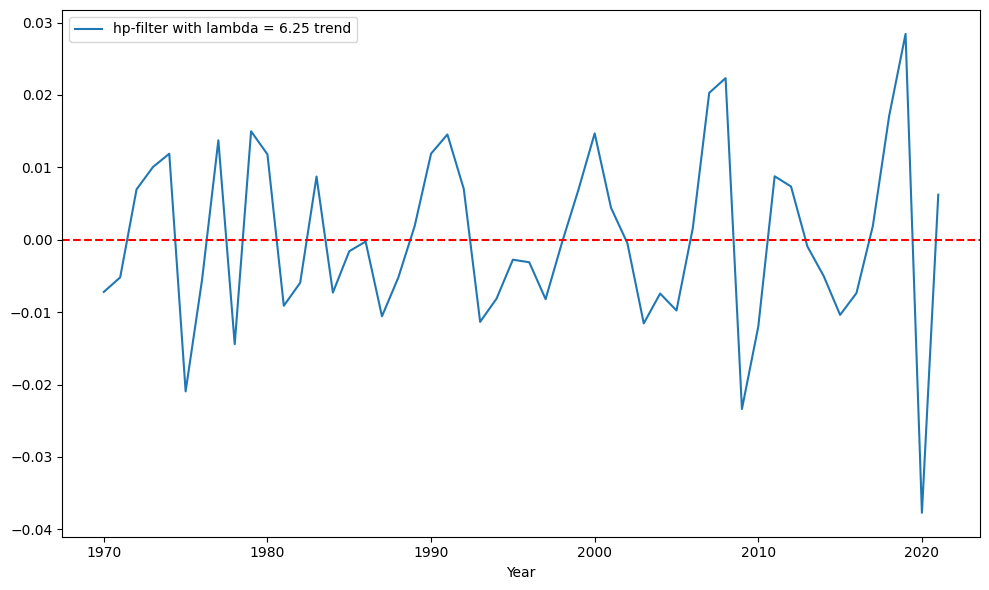

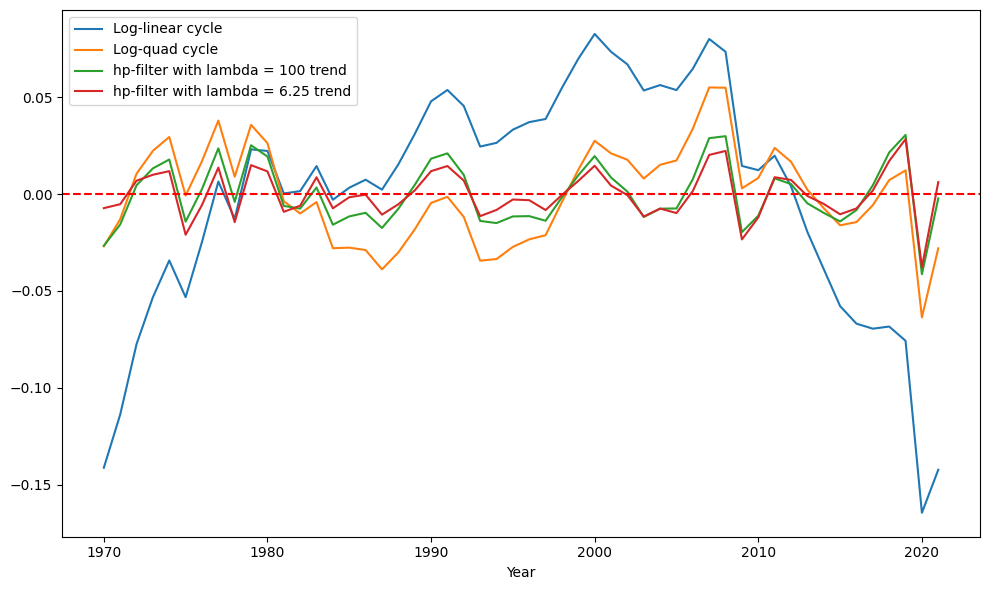

In [13]:
aus_result_1 = solve_first_part_of_task(aus_data_log, indicators)

В данном случае видно очень сильное расхождение лог-линейных циклов с остальными.

### Вторая часть задания
В данной части задания нам необходимо посчитать разные статистики

Посчитаем корреляцию полученых циклов между странами

In [14]:
print(f"Correlation of log-linear cycles:                    f{usa_result_1[methods[0]][0].corr(aus_result_1[methods[0]][0])}")
print(f"Correlation of log-quad cycles:                      f{usa_result_1[methods[1]][0].corr(aus_result_1[methods[1]][0])}")
print(f"Correlation of hp-filters with lambda = 100  cycles: f{usa_result_1[methods[2]][0].corr(aus_result_1[methods[2]][0])}")
print(f"Correlation of hp-filters with lambda = 6.25 cycles: f{usa_result_1[methods[3]][0].corr(aus_result_1[methods[3]][0])}")

Correlation of log-linear cycles:                    f0.8271794593994302
Correlation of log-quad cycles:                      f0.48575155935784914
Correlation of hp-filters with lambda = 100  cycles: f0.4718634190032729
Correlation of hp-filters with lambda = 6.25 cycles: f0.5217295998732828


In [15]:
def create_cycle_array(data):
    return pd.DataFrame({methods[0]:data[methods[0]][0], methods[1]:data[methods[1]][0], methods[2]:data[methods[2]][0], methods[3]:data[methods[3]][0]})

#### Корреляция циклов США

In [16]:
usa_cycle_array = create_cycle_array(usa_result_1)

Смотрим статистики по нашим циклам

In [17]:
usa_cycle_array.describe()

,log-linear,log-quad,hp-filter100,hp-filter6.25
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,2.008991e-13,4.736382e-13,-7.037106e-15,-4.440892e-15
std,4.222539e-02,2.709589e-02,1.958471e-02,1.384609e-02
min,-9.492998e-02,-7.252201e-02,-5.320436e-02,-3.679689e-02
25%,-3.551472e-02,-2.107341e-02,-1.288101e-02,-5.790153e-03
50%,3.895420e-03,-9.932322e-04,-2.275514e-04,2.715052e-04
75%,3.563311e-02,1.924535e-02,1.401387e-02,9.104504e-03
max,7.650053e-02,4.977032e-02,3.411315e-02,3.034372e-02


Смотрим ковариации

In [18]:
usa_cycle_array.cov()

,log-linear,log-quad,hp-filter100,hp-filter6.25
log-linear,0.001783,0.000734,0.000452,0.000260
log-quad,0.000734,0.000734,0.000447,0.000260
hp-filter100,0.000452,0.000447,0.000384,0.000247
hp-filter6.25,0.000260,0.000260,0.000247,0.000192


#### Корреляция циклов Австрия

In [19]:
aus_cycle_array = create_cycle_array(aus_result_1)

Смотрим статистики по нашим циклам

In [20]:
usa_cycle_array.describe()

,log-linear,log-quad,hp-filter100,hp-filter6.25
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,2.008991e-13,4.736382e-13,-7.037106e-15,-4.440892e-15
std,4.222539e-02,2.709589e-02,1.958471e-02,1.384609e-02
min,-9.492998e-02,-7.252201e-02,-5.320436e-02,-3.679689e-02
25%,-3.551472e-02,-2.107341e-02,-1.288101e-02,-5.790153e-03
50%,3.895420e-03,-9.932322e-04,-2.275514e-04,2.715052e-04
75%,3.563311e-02,1.924535e-02,1.401387e-02,9.104504e-03
max,7.650053e-02,4.977032e-02,3.411315e-02,3.034372e-02


Смотрим ковариации

In [21]:
usa_cycle_array.cov()

,log-linear,log-quad,hp-filter100,hp-filter6.25
log-linear,0.001783,0.000734,0.000452,0.000260
log-quad,0.000734,0.000734,0.000447,0.000260
hp-filter100,0.000452,0.000447,0.000384,0.000247
hp-filter6.25,0.000260,0.000260,0.000247,0.000192


#### Таблица 1.3

Теперь необходимо реализовать подобие таблицы 1.3 из учебника Uribe для этого нам нужны бизнес циклы для всех индикаторов, которые у нас есть. посчитаем их с помощью hpfilter lambda = 10

In [22]:
def calc_all_cycles(data):
    return [hp_filter(data, indicators[0], 100, False),    # 'GDP per capita'
            hp_filter(data, indicators[1], 100, False),    # 'Households and NPISHs final consumption expenditure'   
            hp_filter(data, indicators[2], 100, False),    # 'Gross capital formation'
            hp_filter(data, indicators[3], 100, False),    # 'General government final consumption expenditure'    
            hp_filter(data, indicators[4], 100, False),    # 'Imports of goods and services'    
            hp_filter(data, indicators[5], 100, False),]   # 'Exports of goods and services'    

def calc_all_std(data):
    return [data[0][0].std(),
            data[1][0].std(),
            data[2][0].std(),
            data[3][0].std(),
            data[4][0].std(),
            data[5][0].std()] 

In [23]:
usa_cycles = calc_all_cycles(usa_data_log)
aus_cycles = calc_all_cycles(aus_data_log)
usa_cycles_std = calc_all_std(usa_cycles)
aus_cycles_std = calc_all_std(aus_cycles)

Получаем все необходимые для расчётов значения и строим таблицу

In [24]:
name_1 = 'std_' + indicators_info[indicators[0]]
name_2 = 'std_' + indicators_info[indicators[1]]
name_3 = 'std_' + indicators_info[indicators[2]]
name_4 = 'std_' + indicators_info[indicators[3]]
name_5 = 'std_' + indicators_info[indicators[4]]
name_6 = 'std_' + indicators_info[indicators[5]]
cycle_name_1 = 'cycle '+ indicators[0]
cycle_name_2 = 'cycle '+ indicators[0]
cycle_name_3 = 'cycle '+ indicators[0]
cycle_name_4 = 'cycle '+ indicators[0]
cycle_name_5 = 'cycle '+ indicators[0]
cycle_name_6 = 'cycle '+ indicators[0]
Name_row = [name_1, name_2, name_3, name_4, name_5, name_6, \
                                          f'{name_2}/{name_1}', f'{name_3}/{name_1}',  f'{name_4}/{name_1}', \
                                            f'{name_5}/{name_1}', f'{name_6}/{name_1}', \
                              f'corr({cycle_name_1}, {cycle_name_2})', f'corr({cycle_name_1}, {cycle_name_3})', \
                                f'corr({cycle_name_1}, {cycle_name_4})', f'corr({cycle_name_1}, {cycle_name_5})', f'corr({cycle_name_1}, {cycle_name_6})']
Austria_row = [aus_cycles_std[0], aus_cycles_std[1], aus_cycles_std[2], \
                                  aus_cycles_std[3], aus_cycles_std[4], aus_cycles_std[5], \
                            aus_cycles_std[1]/aus_cycles_std[0], aus_cycles_std[2]/aus_cycles_std[0], \
                              aus_cycles_std[3]/aus_cycles_std[0], aus_cycles_std[4]/aus_cycles_std[0], aus_cycles_std[5]/aus_cycles_std[0], \
                              np.corrcoef(aus_cycles[0], aus_cycles[1]), np.corrcoef(aus_cycles[0], aus_cycles[2]), np.corrcoef(aus_cycles[0], aus_cycles[3]), \
                                np.corrcoef(aus_cycles[0], aus_cycles[4]), np.corrcoef(aus_cycles[0], aus_cycles[5])]
USA_row = [usa_cycles_std[0], usa_cycles_std[1], usa_cycles_std[2], \
                                  usa_cycles_std[3], usa_cycles_std[4], usa_cycles_std[5], \
                            usa_cycles_std[1]/usa_cycles_std[0], usa_cycles_std[2]/usa_cycles_std[0], \
                              usa_cycles_std[3]/usa_cycles_std[0], usa_cycles_std[4]/usa_cycles_std[0], usa_cycles_std[5]/usa_cycles_std[0], \
                              np.corrcoef(usa_cycles[0], usa_cycles[1]), np.corrcoef(usa_cycles[0], usa_cycles[2]), np.corrcoef(usa_cycles[0], usa_cycles[3]), \
                                np.corrcoef(usa_cycles[0], usa_cycles[4]), np.corrcoef(usa_cycles[0], usa_cycles[5])]
result_2_table = pd.DataFrame({"Name": Name_row,
                          "Austria": Austria_row,
                          "USA": USA_row})

Округлим для удобства

In [25]:
def round_values(value):
    if isinstance(value, (float, np.float64)):
        return round(value, 5)
    elif isinstance(value, np.ndarray):
        return np.round(value, 5)
    else:
        return value
result_2_table_rounded = result_2_table.applymap(round_values)

Учтите, что у нас вместо обычной корреляции в пункте корреляции стоят коэффиценты корреляции Пирсона

In [26]:
result_2_table_rounded

,Name,Austria,USA
0,std_GDP per capita,0.01578,0.01958
1,std_Households and NPISHs final consumption ex...,0.01203,0.00691
2,std_Gross capital formation,0.03809,0.04857
3,std_General government final consumption expen...,0.02439,0.02927
4,std_Imports of goods and services,0.04196,0.05428
5,std_Exports of goods and services,0.04027,0.078
6,std_Households and NPISHs final consumption ex...,0.76196,0.35258
7,std_Gross capital formation/std_GDP per capita,2.41319,2.4801
8,std_General government final consumption expen...,1.54498,1.49446
9,std_Imports of goods and services/std_GDP per ...,2.65809,2.77138


Для удобства просмотра матриц корреляции выведим их отдельно

Австрия

In [29]:
print(np.corrcoef(aus_cycles[0], aus_cycles[1]),"\n--\n", np.corrcoef(aus_cycles[0], aus_cycles[2]),"\n--\n", np.corrcoef(aus_cycles[0], aus_cycles[3]),"\n--\n", \
                                np.corrcoef(aus_cycles[0], aus_cycles[4]),"\n--\n", np.corrcoef(aus_cycles[0], aus_cycles[5]))

[[ 1.          0.02033277 -0.34392385  0.01273927]
 [ 0.02033277  1.          0.00208283 -0.77712332]
 [-0.34392385  0.00208283  1.          0.07037056]
 [ 0.01273927 -0.77712332  0.07037056  1.        ]] 
--
 [[ 1.          0.02033277  0.59622137 -0.0302687 ]
 [ 0.02033277  1.         -0.00359061 -0.84126583]
 [ 0.59622137 -0.00359061  1.          0.12289541]
 [-0.0302687  -0.84126583  0.12289541  1.        ]] 
--
 [[ 1.          0.02033277 -0.5766056   0.02544082]
 [ 0.02033277  1.          0.00526873  0.9192382 ]
 [-0.5766056   0.00526873  1.          0.06884554]
 [ 0.02544082  0.9192382   0.06884554  1.        ]] 
--
 [[1.         0.02033277 0.55411737 0.02961405]
 [0.02033277 1.         0.00812578 0.96378501]
 [0.55411737 0.00812578 1.         0.02764428]
 [0.02961405 0.96378501 0.02764428 1.        ]] 
--
 [[1.         0.02033277 0.49154459 0.02236752]
 [0.02033277 1.         0.0077955  0.9613379 ]
 [0.49154459 0.0077955  1.         0.04118203]
 [0.02236752 0.9613379  0.04118203 

In [31]:
print(np.corrcoef(usa_cycles[0], usa_cycles[1]),"\n--\n", np.corrcoef(usa_cycles[0], usa_cycles[2]),"\n--\n", np.corrcoef(usa_cycles[0], usa_cycles[3]),"\n--\n", \
                                np.corrcoef(usa_cycles[0], usa_cycles[4]),"\n--\n", np.corrcoef(usa_cycles[0], usa_cycles[5]))

[[ 1.          0.01295703 -0.3712549   0.01010779]
 [ 0.01295703  1.          0.00475859  0.9921027 ]
 [-0.3712549   0.00475859  1.          0.02225513]
 [ 0.01010779  0.9921027   0.02225513  1.        ]] 
--
 [[ 1.          0.01295703  0.76853359  0.10725821]
 [ 0.01295703  1.          0.00741569 -0.75745564]
 [ 0.76853359  0.00741569  1.          0.20648399]
 [ 0.10725821 -0.75745564  0.20648399  1.        ]] 
--
 [[ 1.          0.01295703 -0.63175205 -0.01591607]
 [ 0.01295703  1.         -0.00225782 -0.88430176]
 [-0.63175205 -0.00225782  1.          0.17418682]
 [-0.01591607 -0.88430176  0.17418682  1.        ]] 
--
 [[1.         0.01295703 0.46773611 0.00463129]
 [0.01295703 1.         0.00184709 0.96233257]
 [0.46773611 0.00184709 1.         0.06815804]
 [0.00463129 0.96233257 0.06815804 1.        ]] 
--
 [[ 1.          0.01295703 -0.0802386  -0.04797779]
 [ 0.01295703  1.         -0.00919286  0.9618767 ]
 [-0.0802386  -0.00919286  1.          0.14040404]
 [-0.04797779  0.961876

ВЫВОДЫ: Если смотреть метод фильтра Ходрик-Перскотта , то можно заметить, что волатильность потребления государственного сектора больше, чем у выпуска, а также потребление гос. сектора имеет отрицательную корреляцию с GDP. Т.е. факты из учебника мы подтвердили на практики. Если мы смотрим на GDP по hp-фильтру, то позитивную кореляцию с GDP импотр товаров и валовое накопление капитала. Большая корреляция просматривается между циклами ВВП и валового накопления капитала.